In [1]:
import pandas as pd
#Import daily data from john hopkins database
urlinf = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
infected = pd.read_csv(urlinf, error_bad_lines=False)
urldeaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(urldeaths, error_bad_lines=False)
urlrecovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(urlrecovered, error_bad_lines=False)
#Delete Lat and Long columns
infected = infected.drop(["Province/State","Lat","Long"], axis=1)
deaths = deaths.drop(["Province/State","Lat","Long"], axis=1)
recovered = recovered.drop(["Province/State","Lat","Long"], axis=1)

infected = infected.groupby(by=['Country/Region'], as_index=False).sum()
deaths = deaths.groupby(by=['Country/Region'], as_index=False).sum()
recovered = recovered.groupby(by=['Country/Region'], as_index=False).sum()

In [2]:
Selection = 'US'
startday = 60

In [3]:
infected.insert(1, 'Status', 'infected')
recovered.insert(1, 'Status', 'recovered')
deaths.insert(1, 'Status', 'death')

In [4]:
dfs = [deaths, recovered]
data = infected.append(dfs)
#total_rows1 = df['Country/Region'].count
#print (total_rows1)
data.head()

,Country/Region,Status,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,Afghanistan,infected,0,0,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,Albania,infected,0,0,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,Algeria,infected,0,0,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,Andorra,infected,0,0,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,Angola,infected,0,0,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


In [5]:
database = data.melt(id_vars=["Country/Region", "Status"], 
            var_name="Date", 
            value_name="Value")
database.columns = ['Country', 'Status','Date','Value']

In [7]:
inf = database.loc[(database['Country'] == Selection) & (database['Status'] == 'infected')]
rec = database.loc[(database['Country'] == Selection) & (database['Status'] == 'recovered')]
dea = database.loc[(database['Country'] == Selection) & (database['Status'] == 'death')]
inf.head()

,Country,Status,Date,Value
174,US,infected,1/22/20,1
738,US,infected,1/23/20,1
1302,US,infected,1/24/20,2
1866,US,infected,1/25/20,2
2430,US,infected,1/26/20,5


In [12]:
import numpy as np
inflist = inf["Value"].tolist()
reclist = rec["Value"].tolist()
dealist = dea["Value"].tolist()
I_data = np.asarray(inflist)
R_data = np.asarray(reclist)
D_data = np.asarray(dealist) 
Days = np.linspace(0,len(I_data)-startday,len(I_data)-startday)
D_data[50]

41

In [13]:
import pylab as pp
import numpy as np
from scipy import integrate, interpolate
from scipy import optimize

##initialize the data
def f(y, t, k): 
    """define the ODE system in terms of 
        dependent variable y,
        independent variable t, and
        optinal parmaeters, in this case a single variable k """
    S = y[0]
    I = y[1]
    R = y[2]
    D = y[3]
    a = k[0]
    r = k[1]
    d = k[2]
    return (-k[0]*y[0]*y[1], (k[0]*y[0]*y[1])-((k[1]+k[2])*y[1]), k[1]*y[1] ,k[2]*y[1])

def my_ls_func(x,teta):
    """definition of function for LS fit
        x gives evaluation points,
        teta is an array of parameters to be varied for fit"""
    # create an alias to f which passes the optional params    
    f2 = lambda y,t: f(y, t, teta)
    # calculate ode solution, retuen values for each entry of "x"
    r = integrate.odeint(f2,y0,x)
    #in this case, we only need one of the dependent variable values
    return r[:,2]

def f_resid(p):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        (f_resid,guess)this function"""
  
    return I_data[startday:]-my_ls_func(Days,p)


C:\Users\User\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


parameter values are  [ 5.56902806e+07  5.95159170e-01 -5.96412868e-01]


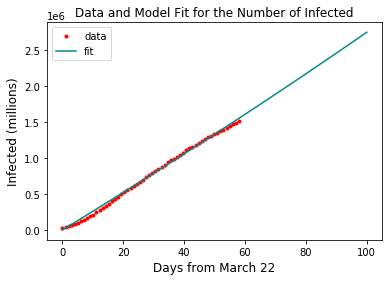

In [14]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
#solve the system - the solution is in variable c
guess = [1.27445112,0.1977401,0.07671102] #initial guess for params
y0 = [10000,I_data[startday],R_data[startday],D_data[startday]] #inital conditions for ODEs
(c,kvg) = optimize.leastsq(f_resid,guess)#get params
print ("parameter values are ",c)

# fit ODE results to interpolating spline just for fun
xeval=np.linspace(min(Days),max(Days),len(Days)) 
gls = interpolate.UnivariateSpline(xeval, my_ls_func(xeval,c), k=5, s=1)
#pick a few more points for a very smooth curve, then plot 
#   data and curve fit
xeval=np.linspace(min(Days),100,len(Days))

#Plot of the data as red dots and fit as blue line
plt.plot(Days, I_data[startday:],'.r',xeval,gls(xeval),'darkcyan')
plt.title('Data and Model Fit for the Number of Infected')
plt.xlabel('Days from March 22',{"fontsize":12})
plt.ylabel("Infected (millions)",{"fontsize":12})
plt.legend(('data','fit'),loc=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("Infectedfit.png",dpi=400)
plt.show()

In [15]:
a = np.transpose(I_data[startday:] + D_data[startday:])
R0 = (I_data[startday:] + R_data[startday:] + D_data[startday:])/(R_data[startday:] + D_data[startday:])
d = D_data[startday:]/(I_data[startday:] - R_data[startday:] - D_data[startday:])
r = R_data[startday:]/(I_data[startday:] - R_data[startday:] - D_data[startday:])
a = R0*(r+d)

In [16]:
my_ls_func(xeval,c)
r

array([0.0054749 , 0.00415122, 0.00664376, 0.00563174, 0.00836311,
       0.00882028, 0.00911084, 0.01976651, 0.0371328 , 0.03995881,
       0.04274035, 0.03970446, 0.03785675, 0.0517477 , 0.05683776,
       0.05882971, 0.06059298, 0.06090351, 0.06091845, 0.06463679,
       0.06642112, 0.06647603, 0.08538154, 0.09017927, 0.09445895,
       0.09463172, 0.09696894, 0.10331355, 0.10862404, 0.1080605 ,
       0.10874309, 0.10811755, 0.10849342, 0.13126767, 0.1280211 ,
       0.13308356, 0.13579118, 0.13830042, 0.14066291, 0.18058702,
       0.18755224, 0.19688411, 0.19792443, 0.20251592, 0.20115719,
       0.19660112, 0.1977401 , 0.19746149, 0.20873072, 0.20914892,
       0.22497888, 0.21792354, 0.22903363, 0.22701301, 0.22701343,
       0.24162998, 0.24202839, 0.24954375])

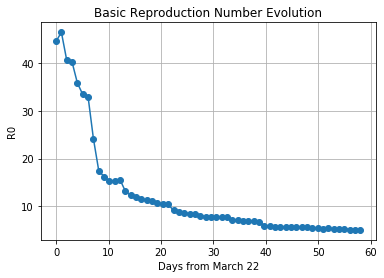

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(Days,R0,'-o')
plt.title('Basic Reproduction Number Evolution')
plt.xlabel('Days from March 22')
plt.ylabel("R0")
plt.grid()
plt.savefig('R0.png',dpi=400)
pp.show()

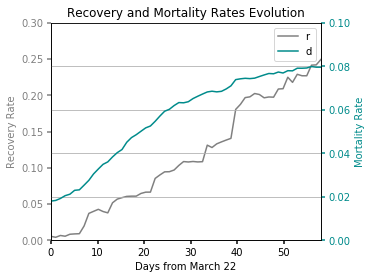

In [18]:
import matplotlib.pyplot as plt


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
# Second, show the right spine.

p1, = host.plot(Days, r, "gray", label="r")
p2, = par1.plot(Days, d, "darkcyan", label="d")

host.set_xlim(0, len(Days))
host.set_ylim(0, 0.3)
par1.set_ylim(0, 0.1)

host.set_xlabel("Days from March 22")
host.set_ylabel("Recovery Rate")
par1.set_ylabel("Mortality Rate")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines])
plt.title('Recovery and Mortality Rates Evolution')
plt.grid()
plt.show()
fig.savefig('rates.png',dpi=400)